# Triage Experiment Report


In [1]:
import pandas as pd
import sqlalchemy
import os
import logging

from sqlalchemy.engine.url import URL
from triage.util.db import create_engine

from triage.component.postmodeling.experiment_summarizer import ExperimentReport, get_most_recent_experiment_hash, load_report_parameters_from_config

import matplotlib.pyplot as plt

pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rcParams.update({"figure.dpi": 120})

# suppress logging messages that make report long
logging.getLogger().setLevel(logging.CRITICAL)

%matplotlib inline

## Database Connection

In [3]:
db_url = URL(
            'postgres',
            host=os.getenv('PGHOST'),
            username=os.getenv('PGUSER'),
            database=os.getenv('PGDATABASE'),
            password=os.getenv('PGPASSWORD'),
            port=5432,
        )

db_engine = create_engine(db_url)

## 1. Initializing the Report
Initializing the Report generation class. Before we do that, we need to establish some parameters

#### 1.1 Default Parameters
The following values are the default parameters for the report. If you are using this interactively, you can change the parameter values.

In [ ]:
# The most recent completed experiment hash
# Note that this has to be a list
# You can replace the get_most_recent_... function call with your list of experiments to analyse different experiments
experiment_hashes = [get_most_recent_experiment_hash(db_engine)]

# Model Performance metric and threshold defaulting to reacll@1_pct
# You can update these to use different metrics, e.g., precision@, 100_abs
performance_metric = 'precision@'
threshold = '50_abs'

# Bias metric defaults to tpr_disparity and bias metric values for all groups generated (if bias audit specified in the experiment config)
bias_metric = 'tpr_disparity'
bias_priority_groups='teacher_prefix'
### bias_priority_groups example 
bias_priority_groups = {'teacher_prefix': ['Dr.', 'Mr.', 'Mrs.', 'Ms.']} 

In [5]:
experiment_hashes

['07b607edbc5aa5145af46f0dfe02e121']

#### 1.2 Updating the parameters based on the experiment configuration (YAML)

If you set the following parameters in the experiment config, the following codeblock will update the parameters 

```yaml
    scoring:
        # Append these key-value pairs to the scoring section
        priority_metric: 'recall@'
        priority_parameter: '1_pct' 
      
    bias_audit:
        ## Append these key-value pairs to the bias_audit section (if a bias audit is performed)
        priority_metric: 'tpr_disparity'

        priority_groups:
          'race':
            - 'African American'
          'gender':
            - 'Female'
  ```

In [6]:
params = load_report_parameters_from_config(db_engine, experiment_hashes[0])

if params['performance_metric'] is not None:
    performance_metric = params['performance_metric']

if params['threshold'] is not None:
    threshold = params['threshold']

if params['bias_metric'] is not None:
    bias_metric = params['bias_metric']

if params['priority_groups'] is not None:
    bias_priority_groups = params['priority_groups']

In [7]:
params

{'performance_metric': 'precision@',
 'threshold': '50_abs',
 'bias_metric': 'tpr_disparity',
 'priority_groups': {'teacher_prefix': ['Mr.', 'Dr.', 'Mrs.', 'Ms.']}}

In [8]:
performance_metric, threshold, bias_metric, bias_priority_groups

('precision@',
 '50_abs',
 'tpr_disparity',
 {'teacher_prefix': ['Mr.', 'Dr.', 'Mrs.', 'Ms.']})

In [9]:
rep = ExperimentReport(
    engine=db_engine,
    experiment_hashes=experiment_hashes,
    performance_priority_metric=performance_metric,
    threshold=threshold,
    bias_priority_metric=bias_metric,
    bias_priority_groups=bias_priority_groups
)

## 2. Experiment Summary

In [10]:
rep.generate_summary()

Experiment contained 12 temporal splits
Experiment contained 112 distinct as_of_times
On average, your cohorts contained around 296 entities with a baserate of 0.344
You built 82 features organized into 1 groups/blocks
Your model grid specification contained 14 model types with 168 individual models
You successfully built all the 168 models
Your models acheived a best average precision@50_abs of 0.556 over the 12 validation splits, with the Model Group 11,sklearn.ensemble.RandomForestClassifier. Note that model selection is more nuanced than average predictive performance over time. You could use Audition for model selection.
You created 3 subsets of your cohort -- poor, rural, urban
For subset 'poor', Model Group 11, sklearn.ensemble.RandomForestClassifier achieved the best average precision@50_abs of 0.512
For subset 'rural', Model Group 557, triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature achieved the best average precision@50_abs of 0.525
For subset 'urban', Mod

## 3. Visualizing the Temporal Validation Splits

In [11]:
rep.timesplits()

There are 12 train-validation splits


## 4. Modeling Cohorts

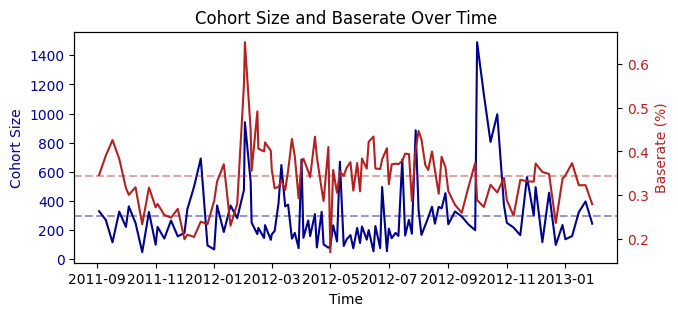

In [12]:
cohort_summary = rep.cohorts(generate_plots=True)

In [13]:
cohort_summary[['cohort_size', 'baserate']].describe()

cohort_size  baserate
count     112.0000  112.0000
mean      296.4018    0.3435
std       235.9918    0.0693
min        47.0000    0.1705
25%       153.5000    0.3052
50%       233.0000    0.3476
75%       359.2500    0.3822
max      1490.0000    0.6489

#### Cohort Subsets

In [14]:
rep.subsets()

config  \
subset_hash                                                                                                                                                                                                                                                                           
65bb3e2f7891cbda8d2adced15c4b304  {'name': 'poor', 'query': 'select 
entity_id
from optimized.projects
where poverty_level in ('high_poverty', 'highest poverty')
and date_posted < '{as_of_date}'::date
', 'cohort_table_name': 'cohort_default_ff6836685f4d1637a6f87f8cee540e48'}   
1dbc92c2b71f32acb02987c830c262f7                               {'name': 'urban', 'query': 'select 
entity_id
from optimized.projects
where school_metro = 'urban'
and date_posted < '{as_of_date}'::date
', 'cohort_table_name': 'cohort_default_ff6836685f4d1637a6f87f8cee540e48'}   
99e87c4eb283725b877fd783d8364a7a                               {'name': 'rural', 'query': 'select 
entity_id
from optimized.projects
where school_metro = 'rural'
and date_posted < '{as_of_date}'::date
', 'cohort_table_name': 'cohort_default_ff6836685f4d1637a6f87f8cee540e48'}   

                                 subset_name  \
subset_hash                                    
65bb3e2f7891cbda8d2adced15c4b304        poor   
1dbc92c2b71f32acb02987c830c262f7       urban   
99e87c4eb283725b877fd783d8364a7a       rural   

                                                                    table_name  
subset_hash                                                                     
65bb3e2f7891cbda8d2adced15c4b304   subet_poor_65bb3e2f7891cbda8d2adced15c4b304  
1dbc92c2b71f32acb02987c830c262f7  subet_urban_1dbc92c2b71f32acb02987c830c262f7  
99e87c4eb283725b877fd783d8364a7a  subet_rural_99e87c4eb283725b877fd783d8364a7a

## 4. Predictors 

In [15]:
features = rep.features()
features

feature_group        feature_name metrics time_horizons  \
0  project_features  total_asking_price     sum           all   
1  project_features        school_metro     sum           all   
2  project_features       resource_type     sum           all   
3  project_features       poverty_level     sum           all   
4  project_features         grade_level     sum           all   
5  project_features      teacher_prefix     sum           all   
6  project_features        school_state     sum           all   

            feature_type                          imputation  
0   continuous_aggregate           {"all": {"type": "zero"}}  
1  categorical_aggregate  {"all": {"type": "null_category"}}  
2  categorical_aggregate  {"all": {"type": "null_category"}}  
3  categorical_aggregate  {"all": {"type": "null_category"}}  
4  categorical_aggregate  {"all": {"type": "null_category"}}  
5  categorical_aggregate  {"all": {"type": "null_category"}}  
6  categorical_aggregate  {"all": {"type": "null_category"}}

#### 4.1 Missingness of Features 

In [16]:
rep.feature_missingness()

mean (%)  min (%)  \
donation_features_entity_id_all_teacher_avg_donations_1yr    62.4781      0.0   
donation_features_entity_id_all_teacher_funding_rate_1yr     60.5686      0.0   
donation_features_entity_id_all_teacher_avg_donations_2yr    53.8363      0.0   
donation_features_entity_id_all_teacher_funding_rate_2yr     52.1607      0.0   
donation_features_entity_id_all_district_avg_donations_1yr   31.6839      0.0   
donation_features_entity_id_all_district_funding_rate_1yr    28.9151      0.0   
donation_features_entity_id_all_district_avg_donations_2yr   20.8356      0.0   
donation_features_entity_id_all_district_funding_rate_2yr    18.4579      0.0   
donation_features_entity_id_all_zip_avg_donations_1yr         9.2967      0.0   
donation_features_entity_id_all_zip_funding_rate_1yr          7.7973      0.0   
donation_features_entity_id_all_zip_avg_donations_2yr         4.6881      0.0   
donation_features_entity_id_all_zip_funding_rate_2yr          3.9644      0.0   
resources_features_entity_id_all_item_quantity                1.3722      0.0   
resources_features_entity_id_all_item_unit_price              1.3722      0.0   

                                                            max (%)  
donation_features_entity_id_all_teacher_avg_donations_1yr   91.9355  
donation_features_entity_id_all_teacher_funding_rate_1yr    90.5018  
donation_features_entity_id_all_teacher_avg_donations_2yr   89.0681  
donation_features_entity_id_all_teacher_funding_rate_2yr    88.1720  
donation_features_entity_id_all_district_avg_donations_1yr  53.8947  
donation_features_entity_id_all_district_funding_rate_1yr   48.6316  
donation_features_entity_id_all_district_avg_donations_2yr  36.1702  
donation_features_entity_id_all_district_funding_rate_2yr   36.1702  
donation_features_entity_id_all_zip_avg_donations_1yr       25.7009  
donation_features_entity_id_all_zip_funding_rate_1yr        24.2991  
donation_features_entity_id_all_zip_avg_donations_2yr       17.7994  
donation_features_entity_id_all_zip_funding_rate_2yr        17.7994  
resources_features_entity_id_all_item_quantity              27.3973  
resources_features_entity_id_all_item_unit_price            27.3973

## 5. Model Groups Built

In [17]:
rep.model_groups()

model_group_id  \
0              819   
1               11   
2              820   
3              557   
4              558   
5              559   
6              560   
7              561   
8              562   
9              563   
10             564   
11             565   
12             566   
13             567   

                                                                  model_type  \
0                                              sklearn.dummy.DummyClassifier   
1                                    sklearn.ensemble.RandomForestClassifier   
2                                        sklearn.tree.DecisionTreeClassifier   
3        triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature   
4   triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   
5   triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   
6   triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   
7   triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   
8   triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   
9   triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   
10  triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   
11  triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   
12  triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   
13  triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression   

                                                                                                     hyperparameters  \
0                                                                                              {'strategy': 'prior'}   
1                             {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100, 'min_samples_split': 10}   
2                                                                           {'max_depth': 2, 'min_samples_split': 2}   
3   {'rules': [{'feature': 'project_features_entity_id_all_total_asking_price_sum', 'low_value_high_score': False}]}   
4                                                 {'C': 0.001, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000}   
5                                                  {'C': 0.01, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000}   
6                                                 {'C': 0.001, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 10000}   
7                                                  {'C': 0.01, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 10000}   
8                                                   {'C': 0.1, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 10000}   
9                                                   {'C': 0.1, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000}   
10                                                  {'C': 0.5, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 10000}   
11                                                  {'C': 0.5, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000}   
12                                                    {'C': 1, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 10000}   
13                                                    {'C': 1, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000}   

    num_models  num_time_splits  
0           12               12  
1           12               12  
2           12               12  
3           12               12  
4           12               12  
5           12               12  
6           12               12  
7           12               12  
8           12               12  
9           12               12  
10          12               12  
11          12               12  
12          12               12  
13          12               12

## 6. All Models Built

In [18]:
rep.models()

model_id  model_group_id  \
14      10478              11   
20      10479              11   
16      10480              11   
15      10481              11   
21      10482              11   
13      10483              11   
17      10484              11   
19      10485              11   
22      10486              11   
18      10487              11   
12      10488              11   
23      10489              11   
44      10300             557   
36      10302             557   
46      10304             557   
42      10306             557   
43      10308             557   
37      10310             557   
39      10312             557   
45      10314             557   
41      10316             557   
38      10318             557   
40      10320             557   
47      10322             557   
124     10361             558   
130     10369             558   
138     10380             558   
133     10390             558   
89      10400             558   
69      10410             558   
125     10420             558   
71      10430             558   
123     10442             558   
162     10450             558   
64      10459             558   
101     10469             558   
134     10362             559   
98      10372             559   
128     10381             559   
109     10392             559   
129     10402             559   
57      10412             559   
159     10422             559   
76      10432             559   
51      10441             559   
55      10452             559   
110     10461             559   
78      10472             559   
147     10360             560   
88      10371             560   
61      10379             560   
146     10389             560   
99      10399             560   
84      10409             560   
75      10419             560   
106     10429             560   
82      10439             560   
81      10451             560   
103     10458             560   
105     10468             560   
93      10359             561   
120     10370             561   
53      10382             561   
85      10391             561   
60      10401             561   
73      10411             561   
111     10421             561   
80      10431             561   
166     10440             561   
127     10449             561   
96      10460             561   
149     10470             561   
72      10365             562   
132     10373             562   
122     10383             562   
165     10393             562   
153     10403             562   
114     10414             562   
148     10424             562   
107     10433             562   
102     10444             562   
83      10455             562   
150     10462             562   
50      10471             562   
119     10363             563   
161     10374             563   
116     10384             563   
62      10395             563   
63      10404             563   
164     10413             563   
91      10423             563   
68      10434             563   
126     10446             563   
140     10454             563   
141     10463             563   
65      10473             563   
90      10364             564   
158     10375             564   
100     10385             564   
118     10394             564   
87      10405             564   
136     10415             564   
152     10425             564   
56      10435             564   
163     10445             564   
115     10453             564   
157     10464             564   
52      10475             564   
94      10366             565   
112     10376             565   
156     10386             565   
131     10396             565   
154     10406             565   
108     10416             565   
104     10426             565   
139     10436             565   
48      10443             565   
77      10490             565   
144     10465             565   
54      10474             565   
113     1036

## 7. Model Performance

#### 7.1 Overall Cohort

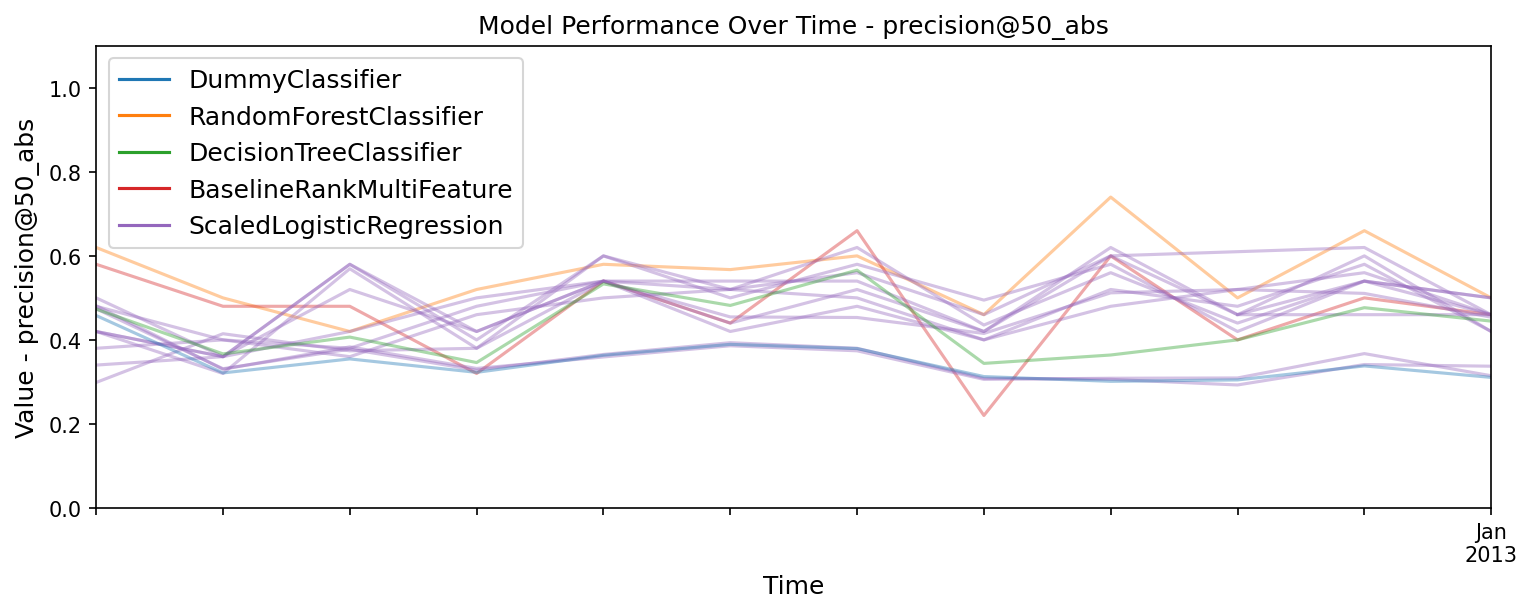

<Figure size 768x576 with 0 Axes>

In [19]:
evaluations = rep.model_performance()

In [20]:
evaluations

model_id train_end_time_dt train_end_time  \
0       10300        2012-02-01     2012-02-01   
38      10361        2012-02-01     2012-02-01   
39      10362        2012-02-01     2012-02-01   
40      10363        2012-02-01     2012-02-01   
41      10364        2012-02-01     2012-02-01   
42      10365        2012-02-01     2012-02-01   
43      10366        2012-02-01     2012-02-01   
44      10367        2012-02-01     2012-02-01   
45      10368        2012-02-01     2012-02-01   
37      10360        2012-02-01     2012-02-01   
13      10336        2012-02-01     2012-02-01   
12      10335        2012-02-01     2012-02-01   
36      10359        2012-02-01     2012-02-01   
155     10478        2012-02-01     2012-02-01   
47      10370        2012-03-01     2012-03-01   
1       10302        2012-03-01     2012-03-01   
156     10479        2012-03-01     2012-03-01   
46      10369        2012-03-01     2012-03-01   
48      10371        2012-03-01     2012-03-01   
49      10372        2012-03-01     2012-03-01   
50      10373        2012-03-01     2012-03-01   
54      10377        2012-03-01     2012-03-01   
52      10375        2012-03-01     2012-03-01   
53      10376        2012-03-01     2012-03-01   
55      10378        2012-03-01     2012-03-01   
15      10338        2012-03-01     2012-03-01   
14      10337        2012-03-01     2012-03-01   
51      10374        2012-03-01     2012-03-01   
56      10379        2012-04-01     2012-04-01   
58      10381        2012-04-01     2012-04-01   
59      10382        2012-04-01     2012-04-01   
60      10383        2012-04-01     2012-04-01   
61      10384        2012-04-01     2012-04-01   
62      10385        2012-04-01     2012-04-01   
63      10386        2012-04-01     2012-04-01   
57      10380        2012-04-01     2012-04-01   
65      10388        2012-04-01     2012-04-01   
2       10304        2012-04-01     2012-04-01   
64      10387        2012-04-01     2012-04-01   
157     10480        2012-04-01     2012-04-01   
16      10339        2012-04-01     2012-04-01   
17      10340        2012-04-01     2012-04-01   
67      10390        2012-05-01     2012-05-01   
3       10306        2012-05-01     2012-05-01   
158     10481        2012-05-01     2012-05-01   
18      10341        2012-05-01     2012-05-01   
19      10342        2012-05-01     2012-05-01   
66      10389        2012-05-01     2012-05-01   
69      10392        2012-05-01     2012-05-01   
68      10391        2012-05-01     2012-05-01   
70      10393        2012-05-01     2012-05-01   
75      10398        2012-05-01     2012-05-01   
74      10397        2012-05-01     2012-05-01   
73      10396        2012-05-01     2012-05-01   
71      10394        2012-05-01     2012-05-01   
72      10395        2012-05-01     2012-05-01   
79      10402        2012-06-01     2012-06-01   
159     10482        2012-06-01     2012-06-01   
84      10407        2012-06-01     2012-06-01   
78      10401        2012-06-01     2012-06-01   
82      10405        2012-06-01     2012-06-01   
76      10399        2012-06-01     2012-06-01   
77      10400        2012-06-01     2012-06-01   
80      10403        2012-06-01     2012-06-01   
85      10408        2012-06-01     2012-06-01   
81      10404        2012-06-01     2012-06-01   
83      10406        2012-06-01     2012-06-01   
4       10308        2012-06-01     2012-06-01   
20      10343        2012-06-01     2012-06-01   
21      10344        2012-06-01     2012-06-01   
92      10415        2012-07-01     2012-07-01   
90      10413        2012-07-01     2012-07-01   
89      10412        2012-07-01     2012-07-01   
88      10411        2012-07-01     2012-07-01   
87      10410        2012-07-01     2012-07-01   
86      10409        2012-07-01     2012-07-01   
94      10417        2012-07-01     2012-07-01   
5       10310        2012-07-01     2012-07-01   
160     10483        2012-07-01     2012-07-01   
22   

#### 7.2 Cohort subsets

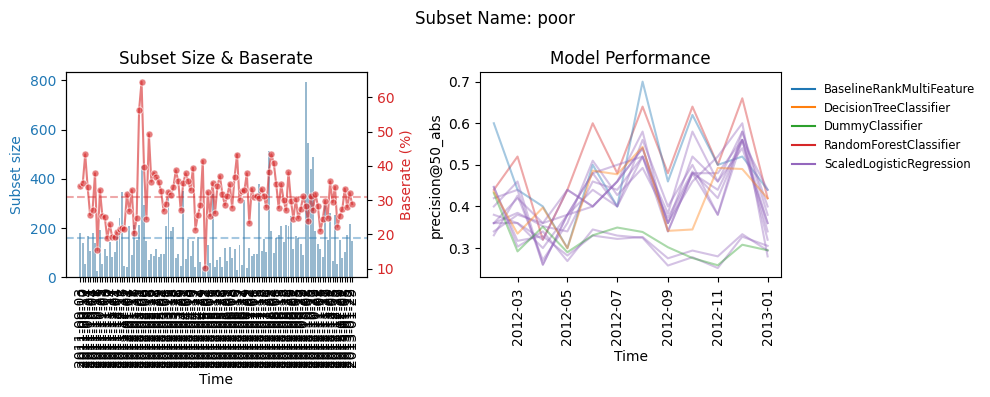

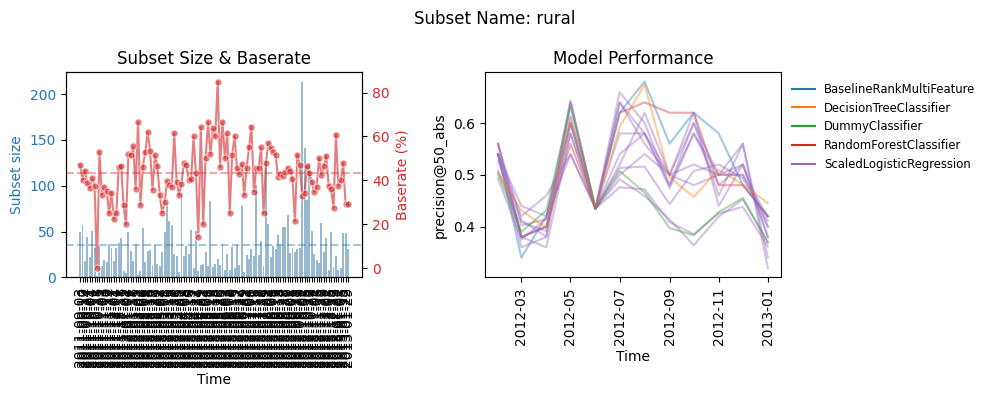

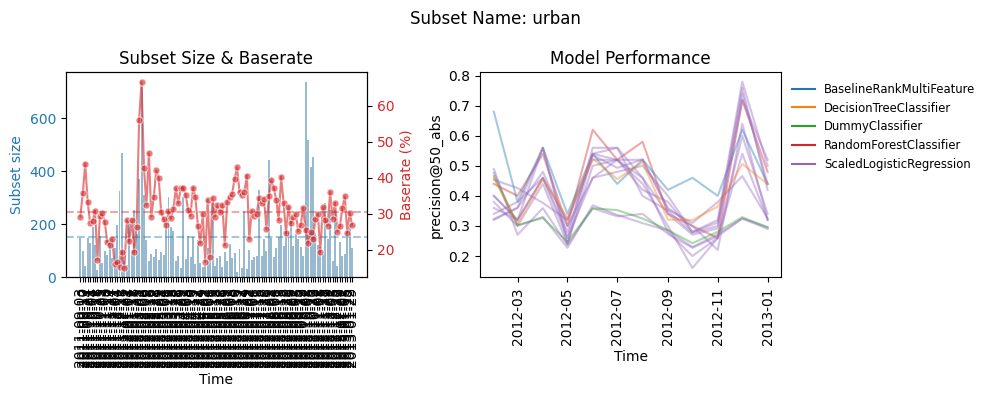

In [21]:
# plot_subset_performance(db_engine, experiment_hashes, parameter,metric)
subset_evaluations = rep.model_performance_subsets()

## 8. Model Performance vs Bias

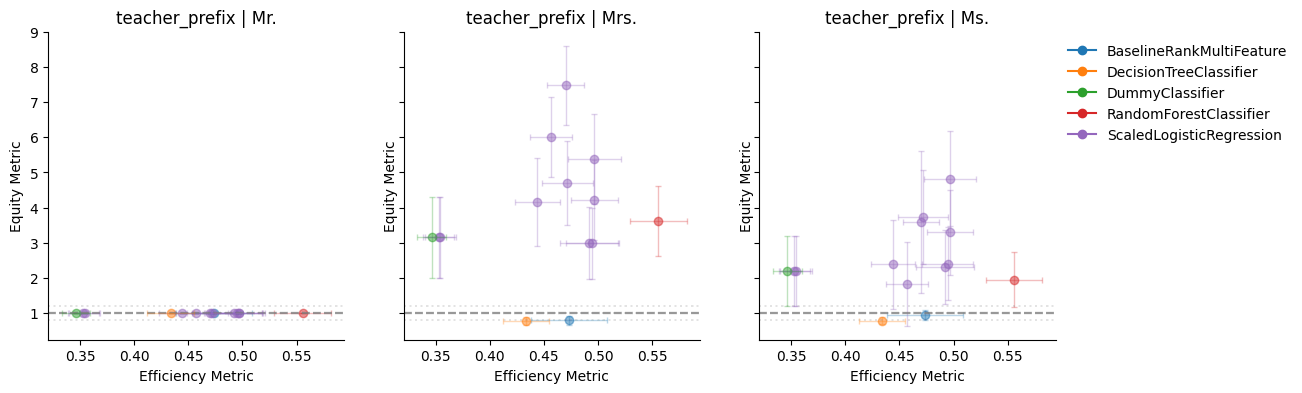

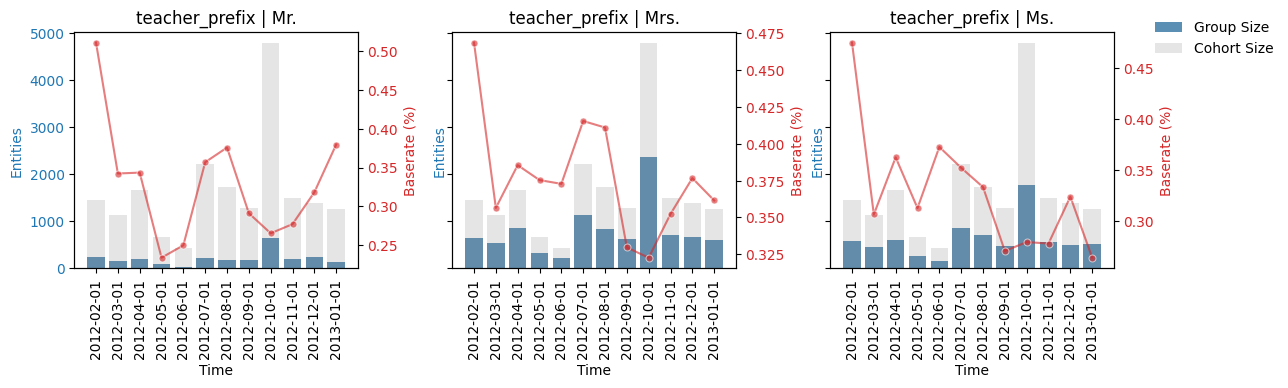

In [22]:
equity_metrics = rep.efficiency_and_equity()

## 9. Initial Model Selection and Further analysis on best models
For the purposes of this report, by default, we pick the best performing model from each model type based on average performance to generate additional outputs about the developed models. We would not assume the existence of predictions at this stage. Therefore, we will not do analysis such as list comparisons, crosstabs, score distribution type stuff. we'll look at more higher level comparisons between the different model types

In [23]:
rep.get_best_hp_config_for_each_model_type()

model_type  \
model_group_id                             
11                RandomForestClassifier   
567             ScaledLogisticRegression   
557             BaselineRankMultiFeature   
820               DecisionTreeClassifier   

                                                                                                                 hyperparameters  \
model_group_id                                                                                                                     
11                                        {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100, 'min_samples_split': 10}   
567                                                               {'C': 1, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000}   
557             {'rules': [{'feature': 'project_features_entity_id_all_total_asking_price_sum', 'low_value_high_score': False}]}   
820                                                                                     {'max_depth': 2, 'min_samples_split': 2}   

                mean_performance  
model_group_id                    
11                        0.5556  
567                       0.4967  
557                       0.4733  
820                       0.4336